In [ ]:
from itertools import combinations
import numpy as np
from copy import deepcopy
import random
import math
import time
import matplotlib.pyplot as plt

In [47]:
def tour_length(tour, dist_matrix):
    return sum(dist_matrix[tour[i], tour[(i+1) % len(tour)]] for i in range(len(tour)))

def random_tour(n):
    t = list(range(n))
    random.shuffle(t)
    return t

## Simple Test Problem

In [48]:
CITIES = [
    "Rome",
    "Milan",
    "Naples",
    "Turin",
    "Palermo",
    "Genoa",
    "Bologna",
    "Florence",
    "Bari",
    "Catania",
    "Venice",
    "Verona",
    "Messina",
    "Padua",
    "Trieste",
    "Taranto",
    "Brescia",
    "Prato",
    "Parma",
    "Modena",
]
test_problem = np.load('lab2/test_problem.npy')

In [ ]:
# Performs Order Crossover (OX): copies a random slice from parent1 into the child 
# and fills the remaining positions with the genes of parent2 in their original order,
# ensuring a valid permutation without duplicates.
def order_crossover(p1, p2):
    n = len(p1)
    a, b = sorted(random.sample(range(n), 2))
    child = [-1]*n
    child[a:b] = p1[a:b]
    fill = [x for x in p2 if x not in child]
    k = 0
    for i in range(n):
        if child[i] == -1:
            child[i] = fill[k]
            k += 1
    return child

# Performs Partially Mapped Crossover (PMX): exchanges segments between 
# two parents and uses a mapping to fill in the remaining positions.
def pmx_crossover(p1, p2):
    n = len(p1)
    a, b = sorted(random.sample(range(n), 2)) 
    child = [-1] * n
    child[a:b] = p1[a:b]
    mapping = {p1[i]: p2[i] for i in range(a, b)}

    for i in range(n):
        if child[i] == -1:
            val = p2[i]
            while val in mapping:
                val = mapping[val]
            child[i] = val

    return child

# Performs Swap Mutation: with a certain probability, 
# selects two positions in the tour and swaps them.
def swap_mutation(tour, mutationRate=0.2):
    if random.random() < mutationRate:
        i, j = random.sample(range(len(tour)), 2)
        tour[i], tour[j] = tour[j], tour[i]
    return tour

# Performs Insertion Mutation: with a certain probability,
# removes a city from one position and reinserts it at another position.
def insert_mutation(tour, rate=0.2):
    if random.random() < rate:
        n = len(tour)
        i, j = random.sample(range(n), 2)
        city = tour.pop(i)
        tour.insert(j, city)
    return tour

# Performs Tournament Selection: selects the lowest fitness individual
# from k randomly chosen individuals, repeated until a new population is formed.
def tournament_selection(pop, fitnesses, k=3):
    selected = []
    pop_idx = list(range(len(pop)))
    for _ in range(len(pop)):
        contenders = random.sample(pop_idx, k)
        best = min(contenders, key=lambda i: fitnesses[i])
        selected.append(deepcopy(pop[best]))
    return selected

# Nearest Neighbor Heuristic: constructs a tour by starting from a given city
# and repeatedly visiting the nearest unvisited city.
def nearest_neighbor(dist, start):
    n = len(dist)
    unvisited = set(range(n))
    tour = [start]
    unvisited.remove(start)
    while unvisited:
        last = tour[-1]
        nxt = min(unvisited, key=lambda j: dist[last, j])
        tour.append(nxt)
        unvisited.remove(nxt)
    return tour

# Main Genetic Algorithm function for TSP: 
# initializes a population, evaluates fitness, selects parents,
# applies crossover and mutation, and iterates for a set number of generations.
def genetic_algorithm_tsp(distMatrix, crossover_func, mutation_func,
                          popSize=100, generations=500,
                          cxRate=0.9, mutRate=0.2, tournamentK=3,
                          seed=None, seedGreedy=0.3, greedyPerturb=1, maxGreedy=50):
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)
    n = len(distMatrix)

    num_g = min(int(popSize * seedGreedy), maxGreedy)
    if num_g > 0:
        if num_g <= n:
            starts = random.sample(range(n), num_g)
        else:
            starts = [random.randrange(n) for _ in range(num_g)]
        greedy_pop = [nearest_neighbor(distMatrix, s) for s in starts]
        if greedyPerturb > 0:
            for t in greedy_pop:
                for _ in range(greedyPerturb):
                    i, j = random.sample(range(n), 2)
                    t[i], t[j] = t[j], t[i]
    else:
        greedy_pop = []

    pop = greedy_pop + [random_tour(n) for _ in range(popSize - len(greedy_pop))]

    best_sol = None
    best_len = math.inf

    for gen in range(generations):
        fitnesses = [tour_length(p, distMatrix) for p in pop]
        idx = int(np.argmin(fitnesses))
        if fitnesses[idx] < best_len:
            best_len = fitnesses[idx]
            best_sol = deepcopy(pop[idx])

        mates = tournament_selection(pop, fitnesses, k=tournamentK)
        newpop = []
        for i in range(0, popSize, 2):
            p1 = mates[i]
            p2 = mates[(i+1) % popSize]
            if random.random() < cxRate:
                c1 = crossover_func(p1, p2)
                c2 = crossover_func(p2, p1)
            else:
                c1, c2 = p1[:], p2[:]
            newpop.append(mutation_func(c1, mutRate))
            if len(newpop) < popSize:
                newpop.append(mutation_func(c2, mutRate))
        pop = newpop

    return best_sol, best_len

## Common tests

In [50]:
problem = np.load('lab2/problem_r2_100.npy')

In [51]:
# Negative values?
np.any(problem < 0)

np.True_

In [52]:
# Diagonal is all zero?
np.allclose(np.diag(problem), 0.0)

False

In [53]:
# Symmetric matrix?
np.allclose(problem, problem.T)

False

In [54]:
# Triangular inequality
all(
    problem[x, y] <= problem[x, z] + problem[z, y]
    for x, y, z in list(combinations(range(problem.shape[0]), 3))
)

False

## Experiments: GA across categories/sizes with crossover and mutation variants

Below we provide a small harness to:
- load distance matrices for categories g, r1, r2 and sizes 10–1000,
- run the Genetic Algorithm with combinations of crossover {OX, PMX} and mutation {Swap, Insert}.

In [ ]:
CATEGORIES = ['g', 'r1', 'r2']
SIZES = [10, 20, 50, 100, 200, 500, 1000]  

CROSSOVERS = {
    'OX': order_crossover,
    'PMX': pmx_crossover,
}
MUTATIONS = {
    'Swap': swap_mutation,
    'Insert': insert_mutation,
}

POP = 100
GEN = 500
CX_RATE = 0.9
MUT_RATE = 0.2
TOUR_K = 3
SEED = 0

results = []  

In [56]:
for cat in CATEGORIES:
    for size in SIZES:
        dist = np.load(f'lab2/problem_{cat}_{size}.npy')
        n = len(dist)
        pop = POP
        gen = GEN
        if n >= 200:
            pop, gen = 120, 500
        if n >= 500:
            pop, gen = 150, 500
        if n >= 1000:
            pop, gen = 180, 500

        for cx_name, cx in CROSSOVERS.items():
            for mut_name, mut in MUTATIONS.items():
                t0 = time.time()
                best_sol, best_len = genetic_algorithm_tsp(
                    dist, cx, mut,
                    popSize=pop, generations=gen,
                    cxRate=CX_RATE, mutRate=MUT_RATE,
                    tournamentK=TOUR_K, seed=SEED
                )
                dt = time.time() - t0
                results.append({
                    'category': cat,
                    'size': size,
                    'crossover': cx_name,
                    'mutation': mut_name,
                    'best_len': float(best_len),
                    'time_s': dt,
                    'pop': pop,
                    'gen': gen,
                })
                print(f"{cat}-{size:>4} | {cx_name}+{mut_name} -> best={best_len:.2f}, time={dt:.1f}s (pop={pop}, gen={gen})")

g-  10 | OX+Swap -> best=1497.66, time=0.7s (pop=100, gen=500)
g-  10 | OX+Insert -> best=1497.66, time=0.7s (pop=100, gen=500)
g-  10 | PMX+Swap -> best=1497.66, time=0.7s (pop=100, gen=500)
g-  10 | PMX+Insert -> best=1497.66, time=0.7s (pop=100, gen=500)
g-  20 | OX+Swap -> best=1809.41, time=1.2s (pop=100, gen=500)
g-  20 | OX+Insert -> best=1755.51, time=1.1s (pop=100, gen=500)
g-  20 | PMX+Swap -> best=1755.51, time=1.1s (pop=100, gen=500)
g-  20 | PMX+Insert -> best=1755.51, time=1.0s (pop=100, gen=500)
g-  50 | OX+Swap -> best=3210.70, time=2.5s (pop=100, gen=500)
g-  50 | OX+Insert -> best=2877.45, time=2.5s (pop=100, gen=500)
g-  50 | PMX+Swap -> best=2979.95, time=1.9s (pop=100, gen=500)
g-  50 | PMX+Insert -> best=2771.54, time=1.9s (pop=100, gen=500)
g- 100 | OX+Swap -> best=4671.23, time=5.6s (pop=100, gen=500)
g- 100 | OX+Insert -> best=4671.23, time=5.6s (pop=100, gen=500)
g- 100 | PMX+Swap -> best=4671.23, time=3.6s (pop=100, gen=500)
g- 100 | PMX+Insert -> best=4517.4

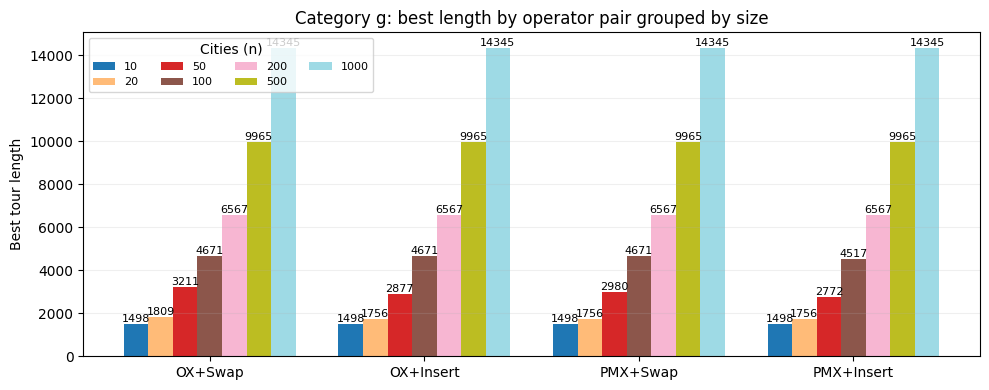

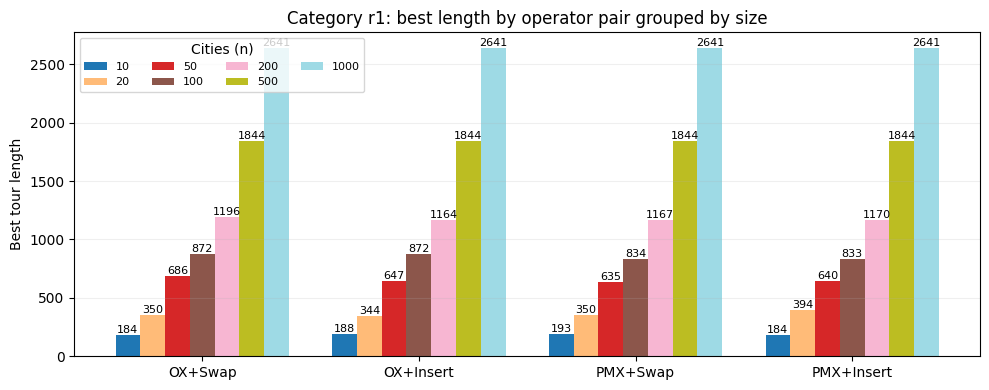

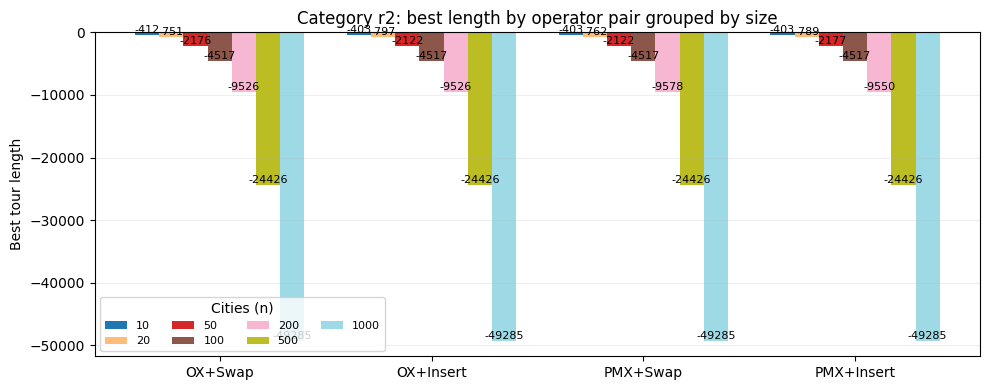

In [61]:
if not results:
    raise RuntimeError("No results found. Run the experiment loop first.")

PAIRS = [f"{cx}+{mut}" for cx in CROSSOVERS.keys() for mut in MUTATIONS.keys()]
CATS = ["g", "r1", "r2"]

idx = {}
for r in results:
    key = (r["category"], r["size"], f"{r['crossover']}+{r['mutation']}")
    idx[key] = r["best_len"]

for cat in CATS:
    sizes = sorted({r["size"] for r in results if r["category"] == cat})
    if not sizes:
        continue

    x = np.arange(len(PAIRS))
    m = len(sizes)
    bar_w = 0.8 / m 
    cmap = plt.get_cmap("tab20", m)
    colors = {s: cmap(i) for i, s in enumerate(sizes)}

    plt.figure(figsize=(10, 4))
    for j, s in enumerate(sizes):
        heights = [idx.get((cat, s, p), np.nan) for p in PAIRS]
        offset = (j - (m - 1) / 2) * bar_w
        bars = plt.bar(x + offset, heights, width=bar_w, label=f"{s}", color=colors[s])
        for b, v in zip(bars, heights):
            if not np.isnan(v):
                plt.text(b.get_x() + b.get_width()/2, v, f"{v:.0f}", ha="center", va="bottom", fontsize=8)

    plt.xticks(x, PAIRS, rotation=0)
    plt.ylabel("Best tour length")
    plt.title(f"Category {cat}: best length by operator pair grouped by size")
    plt.legend(title="Cities (n)", ncol=min(4, m), fontsize=8)
    plt.grid(axis="y", alpha=0.2)
    plt.tight_layout()
    plt.show()